In [3]:
import datetime
import os
import time
from sklearn.preprocessing import MinMaxScaler


import pandas as pd
from openpyxl import load_workbook

import Optim
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from datetime import datetime
import math

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator, MultipleLocator

from hurst import compute_Hc

from layer import DenseGraphConv


np.seterr(divide='ignore',invalid='ignore')


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
import os

# 현재 작업 디렉토리 확인
current_directory = os.getcwd()
print(f"현재 작업 디렉토리: {current_directory}")

# 변경하고자 하는 디렉토리 경로
new_directory = 'C:/Users/sangheon/Desktop/Hurst_TE_RealizedVol'

# 작업 디렉토리 변경
os.chdir(new_directory)

# 변경된 작업 디렉토리 확인
new_current_directory = os.getcwd()
print(f"변경된 작업 디렉토리: {new_current_directory}")


현재 작업 디렉토리: C:\Program Files\JetBrains\PyCharm 2024.1.4\jbr\bin
변경된 작업 디렉토리: C:\Users\sangheon\Desktop\Hurst_TE_RealizedVol


In [4]:
# 각 값이 어떤 bin에 속하는지 인덱싱
def value_to_bin(value_list, m, M, increments):
    result = []
    for v in value_list:
        m_increments = m;
        bin_increments = 0
        while (m_increments < v):
            m_increments = m_increments + increments
            bin_increments = bin_increments + 1
        result.append(bin_increments)
    return result

# calculate omega
def error_cov_matrix(sigma, tau, P):
    matrix = np.diag(np.diag(P.dot(tau * sigma).dot(P.T)))
    return matrix


inc = 0.01
n_random = 25


def TE_caculate(X, increments=inc):
    
    # 최대값, 최소값, bin size
    M = np.max(X)
    M_ceil = np.ceil(M / increments) * increments  # 반올림
    m = np.min(X)
    m_floor = np.floor(m / increments) * increments  # 반내림

    # calculate TE
    TE_matrix = np.zeros((X.shape[1], X.shape[1]))
    for i in range(X.shape[1]):
        for j in range(X.shape[1]):
            if i == j:
                continue
            else:
                # print(v, '->', w)
                xn1 = [r[j] for r in X][1:]
                xn = [r[j] for r in X][:-1]
                yn = [r[i] for r in X][:-1]

                # binning
                xn1_bin = value_to_bin(xn1, m_floor, M_ceil, increments)
                xn_bin = value_to_bin(xn, m_floor, M_ceil, increments)
                yn_bin = value_to_bin(yn, m_floor, M_ceil, increments)

                # bin freq
                xn_freq = list(np.unique(np.array(xn_bin), return_counts=True))
                xn_freq.append(xn_freq[1] / sum(xn_freq[1]))
                xn_xn1_freq = list(np.unique(np.array([xn_bin, xn1_bin]).T, return_counts=True, axis=0))
                xn_xn1_freq.append(xn_xn1_freq[1] / sum(xn_xn1_freq[1]))
                xn_yn_freq = list(np.unique(np.array([xn_bin, yn_bin]).T, return_counts=True, axis=0))
                xn_yn_freq.append(xn_yn_freq[1] / sum(xn_yn_freq[1]))
                xn_xn1_yn_freq = list(np.unique(np.array([xn_bin, xn1_bin, yn_bin]).T, return_counts=True, axis=0))
                xn_xn1_yn_freq.append(xn_xn1_yn_freq[1] / sum(xn_xn1_yn_freq[1]))

                # calculate TE
                TE_xy = 0
                for ii, vv in enumerate(xn_xn1_yn_freq[0]):
                    p_in_in1_jn = xn_xn1_yn_freq[2][ii]
                    index_in_in1 = xn_xn1_freq[0].tolist().index(vv[:2].tolist())
                    p_in_in1 = xn_xn1_freq[2][index_in_in1]
                    index_in_jn = xn_yn_freq[0].tolist().index(vv[[0, 2]].tolist())
                    p_in_jn = xn_yn_freq[2][index_in_jn]
                    index_in = xn_freq[0].tolist().index(vv[0])
                    p_in = xn_freq[2][index_in]
                    TE_xy = TE_xy + p_in_in1_jn * np.log2(p_in_in1_jn * p_in / p_in_in1 / p_in_jn)
                TE_matrix[i, j] = TE_xy

    return TE_matrix


def ETE_caculate(X, TE_matrix, increments=inc):
    
    # 최대값, 최소값, bin size
    M = np.max(X);
    M_ceil = np.ceil(M / increments) * increments  # 반올림
    m = np.min(X);
    m_floor = np.floor(m / increments) * increments  # 반내림
    
    # calculate RTE
    RTE_matrix_all = np.zeros([X.shape[1], X.shape[1], n_random])
    for nn in range(n_random):
        # returns_shuffle = np.array(X).T.tolist()
        # random.shuffle(returns_shuffle)
        # returns_shuffle = np.array(returns_shuffle).T.tolist()
        RTE_matrix = np.zeros((X.shape[1], X.shape[1]))
        for i in range(X.shape[1]):
            for j in range(X.shape[1]):
                if i==j:
                    continue
                else:
                    xn1 = [r[j] for r in X][1:]
                    xn = [r[j] for r in X][:-1]
                    yn = [r[i] for r in X][:-1]
                    # binning
                    xn1_bin = value_to_bin(xn1, m_floor, M_ceil, increments)
                    xn_bin = value_to_bin(xn, m_floor, M_ceil, increments)
                    yn_bin = value_to_bin(yn, m_floor, M_ceil, increments)
                    np.random.shuffle(yn_bin)
    
                    # bin freq
                    xn_freq = list(np.unique(np.array(xn_bin), return_counts=True))
                    xn_freq.append(xn_freq[1]/sum(xn_freq[1]))
                    xn_xn1_freq = list(np.unique(np.array([xn_bin, xn1_bin]).T, return_counts=True, axis=0))
                    xn_xn1_freq.append(xn_xn1_freq[1]/sum(xn_xn1_freq[1]))
                    xn_yn_freq = list(np.unique(np.array([xn_bin, yn_bin]).T, return_counts=True, axis=0))
                    xn_yn_freq.append(xn_yn_freq[1]/sum(xn_yn_freq[1]))
                    xn_xn1_yn_freq = list(np.unique(np.array([xn_bin, xn1_bin, yn_bin]).T, return_counts=True, axis=0))
                    xn_xn1_yn_freq.append(xn_xn1_yn_freq[1]/sum(xn_xn1_yn_freq[1]))
                    # calculate RTE
                    RTE_xy = 0
                    for ii, vv in enumerate(xn_xn1_yn_freq[0]):
                        p_in_in1_jn = xn_xn1_yn_freq[2][ii]
                        index_in_in1 = xn_xn1_freq[0].tolist().index(vv[:2].tolist())
                        p_in_in1 = xn_xn1_freq[2][index_in_in1]
                        index_in_jn = xn_yn_freq[0].tolist().index(vv[[0, 2]].tolist())
                        p_in_jn = xn_yn_freq[2][index_in_jn]
                        index_in = xn_freq[0].tolist().index(vv[0])
                        p_in = xn_freq[2][index_in]
                        RTE_xy = RTE_xy + p_in_in1_jn * np.log2(p_in_in1_jn * p_in / p_in_in1 / p_in_jn)
                    RTE_matrix[i, j] = RTE_xy
        RTE_matrix_all[:,:,nn] = RTE_matrix
        # calculate ETE
    
    ETE_matrix = np.zeros((X.shape[1], X.shape[1]))
    for i in range(X.shape[1]) :
        for j in range(X.shape[1]):
            if i == j:
                continue
            TE = TE_matrix[i, j]
            rte_array = RTE_matrix_all[i, j, :]
            if TE - np.mean(rte_array) - np.std(rte_array) / n_random ** 0.5 > 0:
                ETE_matrix[i, j] = TE - np.mean(rte_array)
                
    if np.all(ETE_matrix == 0) :
        matrix = np.full((10, 10), 0.001)
        np.fill_diagonal(matrix, 0)
        return matrix
        
    return ETE_matrix

In [5]:
class TENet(nn.Module):
    def __init__(self, args, A, B, window_size):
        super(TENet, self).__init__()
        self.use_cuda = args.CUDA
        self.batch_size = args.BATCH_SIZE
        self.window_size = window_size

        # A와 B 초기화
        A = np.array(A, dtype=np.float32)
        A = A / np.sum(A)
        A_new = np.zeros((args.BATCH_SIZE, args.N_E, args.N_E), dtype=np.float32)
        for i in range(args.BATCH_SIZE):
            A_new[i, :, :] = A

        self.A = torch.from_numpy(A_new).cuda() if self.use_cuda else torch.from_numpy(A_new)
        self.adjs = [self.A]
        self.num_adjs = args.NUM_ADJ
        if self.num_adjs > 1:
            A = np.array(B, dtype=np.float32)
            A = A / np.sum(A, 1)
            A_new = np.zeros((args.BATCH_SIZE, args.N_E, args.N_E), dtype=np.float32)
            for i in range(args.BATCH_SIZE):
                A_new[i, :, :] = A

            self.B = torch.from_numpy(A_new).cuda() if self.use_cuda else torch.from_numpy(A_new)
            self.C = torch.from_numpy(A_new).cuda()
            self.adjs = [self.A,self.B,self.C]

        self.n_e = args.N_E

        # Conv2d 레이어
        self.conv1=nn.Conv2d(1, args.CHANNEL_SIZE, kernel_size = (1,args.K_SIZE[0]),stride=1)
        self.conv2=nn.Conv2d(1, args.CHANNEL_SIZE, kernel_size = (1,args.K_SIZE[1]),stride=1)
        self.conv3=nn.Conv2d(1, args.CHANNEL_SIZE, kernel_size = (1,args.K_SIZE[2]),stride=1)


        # Conv2d의 출력 차원 계산
        d= (len(args.K_SIZE)*(self.window_size) -sum(args.K_SIZE)+ len(args.K_SIZE))*args.CHANNEL_SIZE

        # GNN 레이어
        self.gnn1 = DenseGraphConv(d, args.HID1)
        self.gnn2 = DenseGraphConv(args.HID1, args.HID2)
        self.gnn3 = DenseGraphConv(args.HID2, 1)

        # Highway layer
        self.hw = args.HIGHWAY_WINDOW
        if self.hw > 0:
            self.highway = nn.Linear(self.hw, 1)

    def forward(self,x):
        c=x.permute(0,2,1)
        c=c.unsqueeze(1)
        # if self.decoder != 'GAT':
        a1=self.conv1(c).permute(0,2,1,3).reshape(self.batch_size,self.n_e,-1)
        a2=self.conv2(c).permute(0,2,1,3).reshape(self.batch_size,self.n_e,-1)
        a3=self.conv3(c).permute(0,2,1,3).reshape(self.batch_size,self.n_e,-1)

        x_conv = F.relu(torch.cat([a1, a2, a3], 2))
        # x_conv=F.relu(torch.cat([a1,a2,a3,a4,a5],2))
        x1 = F.relu(self.gnn1(x_conv,self.A))
        x2 = F.relu(self.gnn2(x1,self.A))
        x3 = self.gnn3(x2,self.A)
        x3 = x3.squeeze()
      

        if self.hw>0:
            z = x[:, -self.hw:, :]
            z = z.permute(0, 2, 1)
            z = self.highway(z)
            z = z.squeeze(2)
            x3 = x3 + z
        return x3



In [11]:
# CSV 파일에서 데이터 읽어오기 (파일명과 경로를 지정하세요)
file_path = 'data/df_world.csv' 
df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')

# 로그 리턴 계산
df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))

df_used = df.loc[df.index <= '2018-01-01']

100%|██████████| 3491/3491 [00:02<00:00, 1467.94it/s]


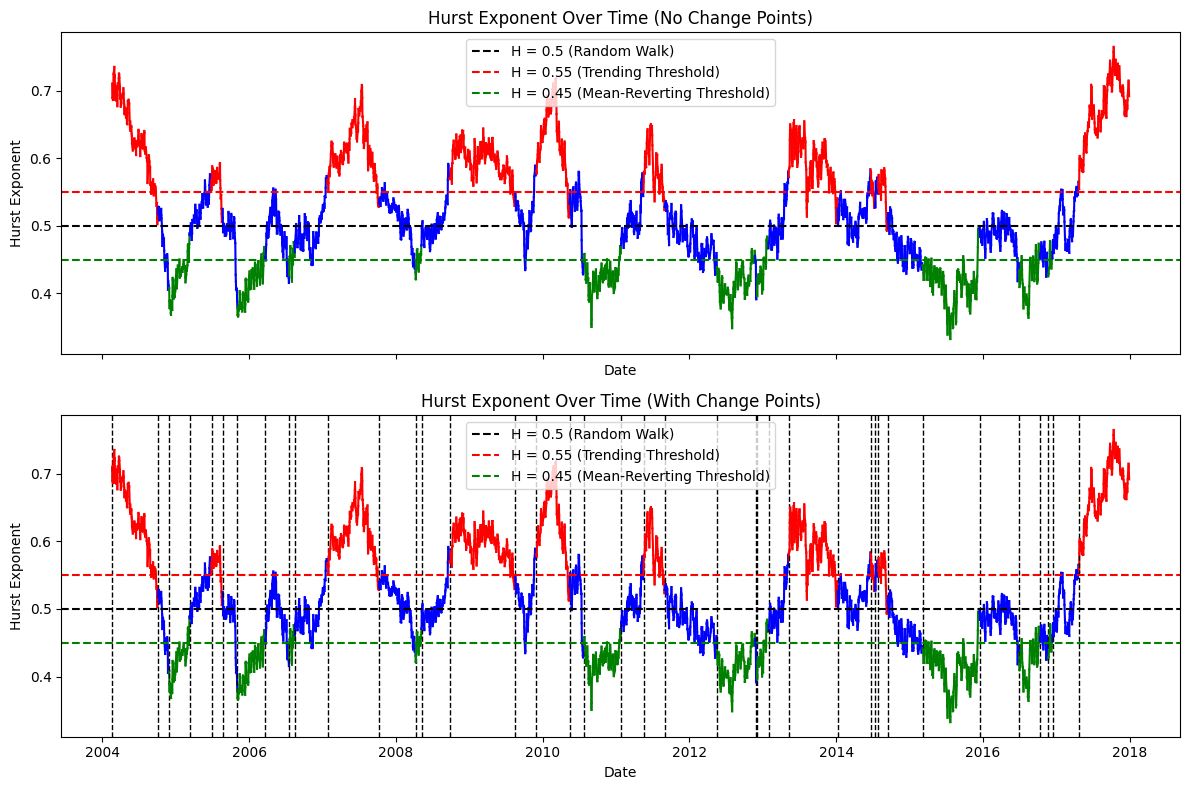

In [21]:
# Hurst exponent를 계산할 창(window)의 크기 설정 (252 거래일 = 1년)
window_size = 250

# Hurst exponent를 저장할 리스트
hurst_series = []

# 날짜를 저장할 리스트
dates_series = []

# 슬라이딩 윈도우를 통해 Hurst exponent 계산
for i in range(window_size, len(df_used)):
    window_data = df_used['Log_Return'].iloc[i-window_size:i].dropna()
    H, _, _ = compute_Hc(window_data, kind='change', simplified=True)
    hurst_series.append(H)
    dates_series.append(df_used.index[i])

# 결과를 시계열 데이터로 변환
hurst_df = pd.DataFrame(data={'Hurst': hurst_series}, index=dates_series)

# 서브플롯을 설정
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# 색상 변경 시점 추적을 위한 변수
prev_color = 'blue'
color_changes = []
period_above = []
period_middle = []
period_below = []
num_prev_colors = 7

# 색상 변경 점선 없는 서브플롯
for i in range(10, len(hurst_df)):
    recent_10_days = hurst_df['Hurst'].iloc[i-10:i]
    
    count_above_55 = (recent_10_days >= 0.55).sum()
    count_between_45_and_55 = ((recent_10_days < 0.55) & (recent_10_days >= 0.45)).sum()
    count_below_45 = (recent_10_days < 0.45).sum()
    
    if count_above_55 >= num_prev_colors:
        color = 'red'
        period_above.append(hurst_df.index[i])
    elif count_between_45_and_55 >= num_prev_colors:
        color = 'blue'
        period_middle.append(hurst_df.index[i])
    elif count_below_45 >= num_prev_colors:
        color = 'green'
        period_below.append(hurst_df.index[i])
    else:
        color = prev_color
    
    axs[0].plot(hurst_df.index[i-1:i+1], hurst_df['Hurst'].iloc[i-1:i+1], color=color)
    
    # 색상 변경 시점 기록
    if color != prev_color:
        color_changes.append(hurst_df.index[i])
        prev_color = color

# 색상 변경 점선 있는 서브플롯
prev_color = 'blue'
for i in tqdm(range(10, len(hurst_df))):
    recent_10_days = hurst_df['Hurst'].iloc[i-10:i]
    
    count_above_55 = (recent_10_days >= 0.55).sum()
    count_between_45_and_55 = ((recent_10_days < 0.55) & (recent_10_days >= 0.45)).sum()
    count_below_45 = (recent_10_days < 0.45).sum()
    
    if count_above_55 >= num_prev_colors:
        color = 'red'
    elif count_between_45_and_55 >= num_prev_colors:
        color = 'blue'
    elif count_below_45 >= num_prev_colors:
        color = 'green'
    else:
        color = prev_color
    
    axs[1].plot(hurst_df.index[i-1:i+1], hurst_df['Hurst'].iloc[i-1:i+1], color=color)
    
    # 색상 변경 시점에 점선 추가
    if color != prev_color:
        axs[1].axvline(hurst_df.index[i], color='black', linestyle='--', linewidth=1)
        prev_color = color

# 기준선 추가
for ax in axs:
    ax.axhline(0.5, color='black', linestyle='--', label='H = 0.5 (Random Walk)')
    ax.axhline(0.55, color='red', linestyle='--', label='H = 0.55 (Trending Threshold)')
    ax.axhline(0.45, color='green', linestyle='--', label='H = 0.45 (Mean-Reverting Threshold)')
    ax.set_xlabel('Date')
    ax.set_ylabel('Hurst Exponent')
    ax.legend()

# 서브플롯 제목
axs[0].set_title('Hurst Exponent Over Time (No Change Points)')
axs[1].set_title('Hurst Exponent Over Time (With Change Points)')

# 그래프 설정
plt.tight_layout()
plt.show()

In [23]:
# 날짜만 추출하여 문자열 리스트로 변환
period_above = [ts.date().strftime('%Y-%m-%d') for ts in period_above]
period_middle = [ts.date().strftime('%Y-%m-%d') for ts in period_middle]
period_below = [ts.date().strftime('%Y-%m-%d') for ts in period_below]


In [ ]:
class WindowedDataset(Dataset):
    def __init__(self, data, data_y, window_size, horizon, scaler_x, scaler_y):
        self.data = data
        self.data_y = data_y
        self.window_size = window_size
        self.horizon = horizon
        self.scaler_x = scaler_x
        self.scaler_y = scaler_y
    
    def __len__(self):
        return len(self.data) - self.window_size - self.horizon + 1
    
    def __getitem__(self, idx):
        # 데이터 슬라이스 추출
        window_data = self.data[idx:idx + self.window_size]
        label = self.data_y[idx]

        # 스케일링 (사전에 학습된 스케일러 사용)
        window_scaled = self.scaler_x.transform(window_data)
        
        # 1차원 배열을 2차원 배열로 변환
        label_scaled = self.scaler_y.transform(np.array([label]))
        
        return torch.tensor(window_scaled, dtype=torch.float32), torch.tensor(label_scaled.flatten(), dtype=torch.float32)

In [1]:
class ModelManager:
    def __init__(self, config, data, window_size, threshold, Effective, training_period):
        self.config = config
        self.window_size = window_size
        self.data = data
        self.data_y = self.calculate_realized_volatility(self.data)  # 최종 출력은 데이터프레임
        self.training_period = training_period
        self.threshold = threshold
        self.Effective = Effective
        self.device = torch.device(config.DEVICE)
        
        self.model_phase_1 = None  # Phase 1 (H < 0.45)
        self.model_phase_2 = None  # Phase 2 (0.45 <= H <= 0.55)
        self.model_phase_3 = None  # Phase 3 (H > 0.55)
        
        self.criterion = nn.MSELoss().to(self.device)
        self.optimizer = None
        self.A = None
        self.B = None
        self.results = []
        self.scaler_x = MinMaxScaler(feature_range=(0, 1))
        self.scaler_y = MinMaxScaler(feature_range=(0, 1))
        self.save_dir = None
        self.test_total_loss_list = []
        self.predictions = []
        self.actuals = []

    def calculate_realized_volatility(self, data):
        realized_vols = []
        for i in range(20, len(data)):
            window_data = data[i - window:i]
            window_data = 100 * window_data
            squared_returns = np.square(window_data)
            realized_vol = np.sqrt(np.mean(squared_returns, axis=0))
            realized_vols.append(realized_vol)
        return np.array(realized_vols)

    def load_model(self, A, B, window_size):
        torch.cuda.empty_cache()
        return TENet(CONFIG, A, B, window_size).to(self.device)

    def train_and_evaluate(self, period_above, period_middle, period_below):
        # 데이터셋을 학습 데이터와 테스트 데이터로 나눔
        train_data_x, test_data_x = self.split_data(self.data_np)
        train_data_y, test_data_y = self.split_data(self.data_y)

        # 각 국면에 맞는 모델 학습
        self.model_phase_1 = self.train_phase(period_below, train_data_x, train_data_y)  # H < 0.45
        self.model_phase_2 = self.train_phase(period_middle, train_data_x, train_data_y)  # 0.45 <= H <= 0.55
        self.model_phase_3 = self.train_phase(period_above, train_data_x, train_data_y)  # H > 0.55

        # 테스트 데이터 예측
        self.test_and_predict(test_data_x, test_data_y)

    def split_data(self, data):
        # 학습 데이터와 테스트 데이터 분리 (7년치)
        num_train_samples = int(0.7 * len(data))  # 7년치 학습 데이터
        return data[:num_train_samples], data[num_train_samples:]

    def train_phase(self, phase_dates, data_x, data_y):
        # 해당 Phase 데이터로 모델 학습
        phase_data_x = data_x.loc[phase_dates]  # 국면별로 날짜 필터링하여 데이터 추출
        phase_data_y = data_y.loc[phase_dates]

        te_matrix = self.calculate_TE(phase_data_x, self.Effective)
        model = self.load_model(te_matrix, te_matrix, self.window_size)
        self.optimizer = torch.optim.Adam(model.parameters(), lr=self.config.LR)

        self.train_model(model, phase_data_x, phase_data_y)

        return model

    def train_model(self, model, x, y):
        model.train()
        train_loader = DataLoader(WindowedDataset(x, y, self.window_size, self.config.HORIZON, self.scaler_x, self.scaler_y), batch_size=self.config.BATCH_SIZE, shuffle=True, drop_last=True)

        for epoch in range(self.config.EPOCHS):
            for x_batch, y_batch in train_loader:
                x_batch, y_batch = x_batch.to(self.device), y_batch.to(self.device)
                self.optimizer.zero_grad()
                predictions = model(x_batch)
                loss = self.criterion(predictions, y_batch)
                loss.backward()
                self.optimizer.step()

    def test_and_predict(self, test_data_x, test_data_y):
        # 테스트 데이터를 예측할 때, Hurst 지수를 기준으로 모델 선택
        hurst_values = []
        for i in range(self.window_size, len(test_data_x)):
            window_data = test_data_x[i - self.window_size:i]
            H, _, _ = compute_Hc(window_data, kind='change', simplified=True)
            hurst_values.append(H)

        for i, H in enumerate(hurst_values):
            if H < 0.45:
                model = self.model_phase_1
            elif 0.45 <= H <= 0.55:
                model = self.model_phase_2
            else:
                model = self.model_phase_3

            # 예측 수행
            test_x = test_data_x[i:i + self.window_size]
            test_y = test_data_y[i]

            with torch.no_grad():
                test_x_tensor = torch.tensor(test_x, dtype=torch.float32).to(self.device)
                pred = model(test_x_tensor.unsqueeze(0))  # (1, window_size, features)
                self.predictions.append(pred.cpu().numpy().flatten())
                self.actuals.append(test_y)

    def calculate_TE(self, data_x, Effective):
        # TE (Transfer Entropy) 계산
        if Effective:
            te_matrix = TE_caculate(data_x)
            ete_matrix = ETE_caculate(data_x, te_matrix)
            return ete_matrix
        else:
            return TE_caculate(data_x)


In [10]:
class Config:
    # Data parameters
    N_E = 10
    MODEL = 'TENet'
    K_SIZE = [3, 5, 7]
    DECODER = 'GNN'
    HORIZON = 1
    NUM_ADJ = 1
    HIGHWAY_WINDOW = 0
    
    EPOCHS = 100
    BATCH_SIZE = 32
    
    
    SKIP_MODE = "none"
    ATTENTION_MODE = "naive"
    CHANNEL_SIZE = 12
    HID1 = 20
    HID2 = 30
    HIDRNN = 100
    RNN_LAYERS = 1
    HIDCNN = 12
    CNN_KERNEL = 6
    N_HEAD = 8
    D_K = 64
    D_V = 64
    SEED = 54321
    
    GPU = 1
    
    LOG_INTERVAL = 2000
    SAVE = 'model/model.pt'
    CUDA = True
    OPTIM = 'adam'
    LR = 0.001
    L1LOSS = False
    SKIP = 24
    HIDSKIP = 10
    NORMALIZE = 1
    OUTPUT_FUN = 'Linear'
    
    DEVICE = 'cuda:1'
    
    GCN_TRUE = True
    BUILDA_TRUE = True
    GCN_DEPTH = 2
    NUM_NODES = 8
    DROPOUT = 0.2
    SUBGRAPH_SIZE = 4
    NODE_DIM = 40
    DILATION_EXPONENTIAL = 2
    CONV_CHANNELS = 12
    RESIDUAL_CHANNELS = 12
    SKIP_CHANNELS = 32
    END_CHANNELS = 64
    IN_DIM = 1
    SEQ_IN_LEN = 32
    SEQ_OUT_LEN = 1
    LAYERS = 5
    WEIGHT_DECAY = 0.00001
    CLIP = 10
    PROPALPHA = 0.05
    TANHALPHA = 3
    NUM_SPLIT = 1
    STEP_SIZE = 100
    VALIDATION_FREQ=10

CONFIG = Config()


CONFIG.CUDA = torch.cuda.is_available()
if CONFIG.CUDA:
    torch.cuda.set_device(CONFIG.GPU)

In [25]:
logR_df = pd.read_csv('data/log_df_etf10.csv')


In [ ]:
import os
import numpy as np

logR_df = pd.read_csv('data/log_df_etf10.csv')

# 실험을 위한 파라미터 값 설정
window_sizes = [30, 60, 90]
training_periods = [750]
effectives = [False, True]

# For문을 통해 모든 조합에 대해 실험 수행
for training_period in tqdm(training_periods, leave=False):
    for window_size in tqdm(window_sizes, leave=False):
        for effective in tqdm(effectives, leave=False):
                    # ModelManager 객체 생성
                    manager = ModelManager(CONFIG, logR_df, window_size=window_size, training_period=training_period, threshold=None, Effective=effective)
                    
                    manager.train_and_evaluate()  # Example sizes in days
                    
                    # 결과 플롯 및 저장
                    manager.plot_results()
                    manager.save_results_to_excel()




  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

initial_data_x and y (750, 10) (720, 10)


In [ ]:
# Configuration and initialization
fin = open("/Users/sangheon/Desktop/CauGNN-main/TENet-master/data/log_df_etf10.txt")
data = np.loadtxt(fin, delimiter=',')
manager = ModelManager(CONFIG, data, threshold=None, Effective=True, volatility_type=1, num_change_te=None, direction=None)
manager.train_and_evaluate(window_size=32, training_period=750, testing_period=250)  # Example sizes in days
manager.plot_results()
manager.save_results_to_excel()

In [ ]:
'''
변수
training period size : big window size of train
testing period size : big window size of test & big window moving size
window_size : small window moving size
threshold : TE or ETE threshold
volatility type : , 0 for log return, 1 for absolute log return, 2 for realized volatility

horizon : 1 (small window moving size) / Fixed
training rate : 0.7 in train set(on training period size) & Shuffled / Fixed
validation rate : 0.3 in train set / Fixed

changing point index(TE 임계값 넘는 지점)
changing point list
TE list
ETE list
Loss list of each stock
Loss list of all


특정 Threshold에 따라 모델 변경
전체 ETF의 TE 평균, inflow TE의 평균, outflow TE의 평균, inflow의 평균이 threshold를 넘는 ETF의 개수, outflow의 평균이 threshold를 넘는 ETF의 개수
총 5개의 경우

공통
window size : 3m, 6m, 1y, 3y, 5y
'''